In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from itertools import chain
from scipy.stats import shapiro, kruskal, mode

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Load NIH data
all_xray_df_ori = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df_ori.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
110840,00030212_001.png,Infiltration,1,30212,44,F,AP,3056,2544,0.139,0.139,NaN
54259,00013631_000.png,Fibrosis|Pleural_Thickening,0,13631,58,F,PA,2992,2969,0.143,0.143,NaN
80762,00019847_005.png,Consolidation,5,19847,32,M,AP,3056,2544,0.139,0.139,NaN


In [3]:
all_xray_df_ori[all_xray_df_ori['Follow-up #']>5].groupby(['Patient ID', 'Follow-up #']).mean()

Patient Age  OriginalImage[Width  Height]  \
Patient ID Follow-up #                                              
3          6                     79                 2992     2991   
           7                     80                 2582     2905   
5          6                     70                 2992     2991   
           7                     70                 2566     2681   
11         6                     75                 2992     2991   
...                             ...                  ...      ...   
30753      10                    55                 2021     2011   
           11                    54                 3056     2544   
           12                    55                 2021     2021   
30786      6                     61                 3056     2544   
           7                     61                 3056     2544   

                        OriginalImagePixelSpacing[x        y]  Unnamed: 11  
Patient ID Follow-up #                                                      
3          6                               0.143000  0.143000          NaN  
           7                               0.143000  0.143000          NaN  
5          6                               0.143000  0.143000          NaN  
           7                               0.143000  0.143000          NaN  
11         6                               0.143000  0.143000          NaN  
...                                             ...       ...          ...  
30753      10                              0.194311  0.194311          NaN  
           11                              0.139000  0.139000          NaN  
           12                              0.194311  0.194311          NaN  
30786      6                               0.139000  0.139000          NaN  
           7                               0.139000  0.139000          NaN  

[41155 rows x 6 columns]

In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5290,00028509_006.png,No Finding,6,28509,064Y,M,AP,3056,2544,0.139,0.139
1179,00006270_006.png,No Finding,6,6270,042Y,M,PA,2992,2991,0.143,0.143
1653,00008626_019.png,Infiltration,19,8626,037Y,M,AP,2500,2048,0.168,0.168


## Exploratory Data Analysis (EDA)

In [5]:
all_xray_df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
# get a count of unique values for each variable
all_xray_df_ori.nunique()
# Observation: Patient ID is 30805 while Image Index is 112120. This means that some xray images belong to the same patients

Image Index                    112120
Finding Labels                    836
Follow-up #                       184
Patient ID                      30805
Patient Age                       107
Patient Gender                      2
View Position                       2
OriginalImage[Width               904
Height]                          1137
OriginalImagePixelSpacing[x        23
y]                                 23
Unnamed: 11                         0
dtype: int64

In [7]:
# drop the last column since it only has null values
# create a copy of the dataframe to preserve the original data for future reference
all_xray_df = all_xray_df_ori.copy()
all_xray_df = all_xray_df.dropna(axis=1)

# rename column names to match sample_df.
all_xray_df = all_xray_df.rename(columns = {'OriginalImage[Width':'OriginalImageWidth',
                              'Height]':'OriginalImageHeight', 
                              'OriginalImagePixelSpacing[x':'OriginalImagePixelSpacing_x',
                              'y]':'OriginalImagePixelSpacing_y'
                             })
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [8]:
## Here I'm going to split up my "Finding Labels" column so that I have one column per disease in my dataframe,
# with a binary flag (0 for Yes; 1 for No). This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for i in all_labels:
    if len(i) > 1: # leave out empty labels
        all_xray_df[i] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if i in x else 0)

all_xray_df.describe()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Follow-up #,Patient ID,Patient Age,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.103095,0.024759,0.041625,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.304084,0.155391,0.199732,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[Text(0, 0.5, 'Number of Images with Label')]

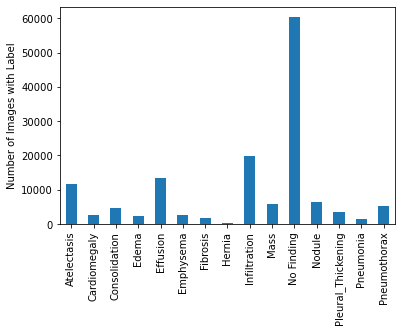

In [9]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in ~54% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, followed by 'Effusion' and 'Atelectasis.'

Since 'Pneumonia' is my target variable, I'm going to look at how frequently it appears with all of the other diseases: 

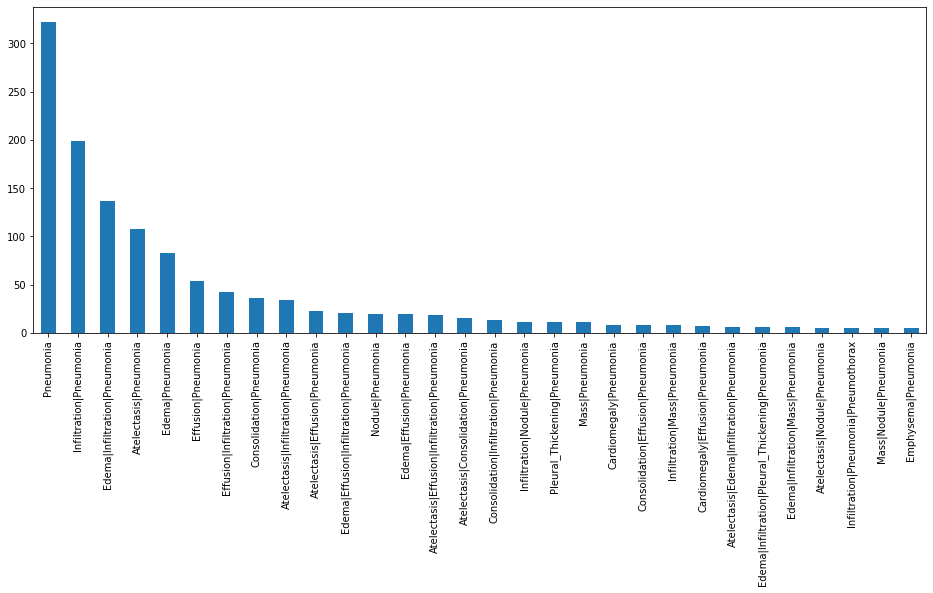

In [10]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like the most-common comorbidities of Pneumonia are Infiltration and Edema, followed by Atelectasis. 

In [11]:
# summary stats for numeric variables
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.103095,0.024759,0.041625,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.304084,0.155391,0.199732,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Observation: a maximum patient age of 414 does not make sense. This value is erraneous.

# Age

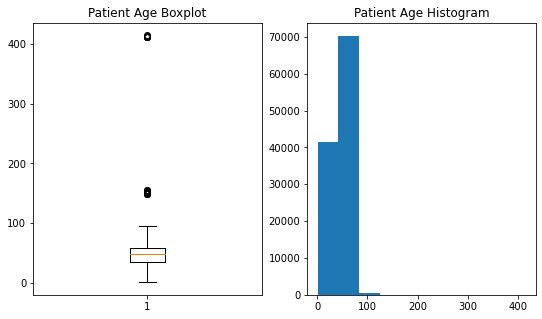

In [12]:
# I will plot a boxplot of the variables to examine their distribution
fig = plt.figure(figsize = (9,5))

plt.subplot(1, 2, 1)
plt.boxplot(all_xray_df['Patient Age'])
plt.title('Patient Age Boxplot')

plt.subplot(1, 2, 2)
plt.hist(all_xray_df['Patient Age'])
plt.title('Patient Age Histogram')
plt.show()

In [13]:
# get a value count of patients' ages above 100
all_xray_df['Patient Age'][all_xray_df['Patient Age'] > 100].value_counts()

412    3
148    2
155    2
414    1
413    1
411    1
154    1
153    1
152    1
151    1
150    1
149    1
Name: Patient Age, dtype: int64

In [14]:
# since the maximum known value of human's age is 122, we will discard data of patients whose reported age is >122
# based on the value counts above, this amounts to a very small proportion of the total data (16/112120)
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 122]

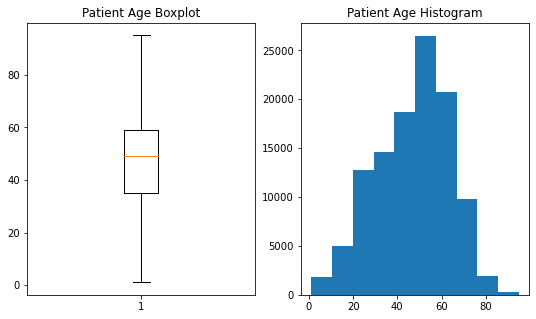

In [15]:
# re-examine boxplot & histogram
fig = plt.figure(figsize = (9,5))

plt.subplot(1, 2, 1)
plt.boxplot(all_xray_df['Patient Age'])
plt.title('Patient Age Boxplot')

plt.subplot(1, 2, 2)
plt.hist(all_xray_df['Patient Age'])
plt.title('Patient Age Histogram')
plt.show()

The data seems much more reasonable.

In [16]:
# summary stats for non-numeric variables
all_xray_df.describe(include = 'O')

,Image Index,Finding Labels,Patient Gender,View Position
count,112104,112104,112104,112104
unique,112104,836,2,2
top,00009691_016.png,No Finding,M,PA
freq,1,60353,63328,67299


Investigate value counts of each category in all_labels, 'Patient Gender', and 'View Position'.

In [17]:
col_cat = all_labels + ['Patient Gender', 'View Position']

for i in col_cat:
  print(all_xray_df[i].value_counts())

0.0    100546
1.0     11558
Name: Atelectasis, dtype: int64
0.0    109328
1.0      2776
Name: Cardiomegaly, dtype: int64
0.0    107437
1.0      4667
Name: Consolidation, dtype: int64
0.0    109802
1.0      2302
Name: Edema, dtype: int64
0.0    98788
1.0    13316
Name: Effusion, dtype: int64
0.0    109588
1.0      2516
Name: Emphysema, dtype: int64
0.0    110418
1.0      1686
Name: Fibrosis, dtype: int64
0.0    111877
1.0       227
Name: Hernia, dtype: int64
0.0    92213
1.0    19891
Name: Infiltration, dtype: int64
0.0    106325
1.0      5779
Name: Mass, dtype: int64
1.0    60353
0.0    51751
Name: No Finding, dtype: int64
0.0    105773
1.0      6331
Name: Nodule, dtype: int64
0.0    108720
1.0      3384
Name: Pleural_Thickening, dtype: int64
0.0    110674
1.0      1430
Name: Pneumonia, dtype: int64
0.0    106803
1.0      5301
Name: Pneumothorax, dtype: int64
M    63328
F    48776
Name: Patient Gender, dtype: int64
PA    67299
AP    44805
Name: View Position, dtype: int64


In [18]:
# get % of occurence
for i in col_cat:
  print(round(all_xray_df[i].value_counts()/all_xray_df[i].value_counts().sum()*100, 1))

0.0    89.7
1.0    10.3
Name: Atelectasis, dtype: float64
0.0    97.5
1.0     2.5
Name: Cardiomegaly, dtype: float64
0.0    95.8
1.0     4.2
Name: Consolidation, dtype: float64
0.0    97.9
1.0     2.1
Name: Edema, dtype: float64
0.0    88.1
1.0    11.9
Name: Effusion, dtype: float64
0.0    97.8
1.0     2.2
Name: Emphysema, dtype: float64
0.0    98.5
1.0     1.5
Name: Fibrosis, dtype: float64
0.0    99.8
1.0     0.2
Name: Hernia, dtype: float64
0.0    82.3
1.0    17.7
Name: Infiltration, dtype: float64
0.0    94.8
1.0     5.2
Name: Mass, dtype: float64
1.0    53.8
0.0    46.2
Name: No Finding, dtype: float64
0.0    94.4
1.0     5.6
Name: Nodule, dtype: float64
0.0    97.0
1.0     3.0
Name: Pleural_Thickening, dtype: float64
0.0    98.7
1.0     1.3
Name: Pneumonia, dtype: float64
0.0    95.3
1.0     4.7
Name: Pneumothorax, dtype: float64
M    56.5
F    43.5
Name: Patient Gender, dtype: float64
PA    60.0
AP    40.0
Name: View Position, dtype: float64


Based on the above, there are a total of 60353 non-pneumonia 'No Finding' cases, comprising 53.8% of the dataset; and 1430 pneumonia cases, comprising 1.3% of the dataset.

In [19]:
# create a function to display % of occurence and number of cases on countplot
def get_totals_dictionary(ax):
    labels = ax.get_xticklabels() # get x labels
    heights = [(x.get_x(), x.get_height()) for x in ax.patches]

    response = dict()
    for x, y in zip(list(heights)[::len(labels)], list(heights)[1::len(labels)]):
        response[x[0]] = x[1] + y[1]
        response[y[0]] = response[x[0]]

        return response

def countplot(**kwargs):
    ax = sns.countplot(**kwargs)      
    
    labels = ax.get_xticklabels() # get x labels
    patch_totals = get_totals_dictionary(ax)
    patch_i = 0
    for p in ax.patches:
        ax.annotate('{:.0f}% ({})'.format(p.get_height()*100/patch_totals[p.get_x()], p.get_height()),
                    (p.get_x() + p.get_width()/4, p.get_height()+2))
        ax.set_xticklabels(labels, rotation=0) # set new labels
        patch_i +=1

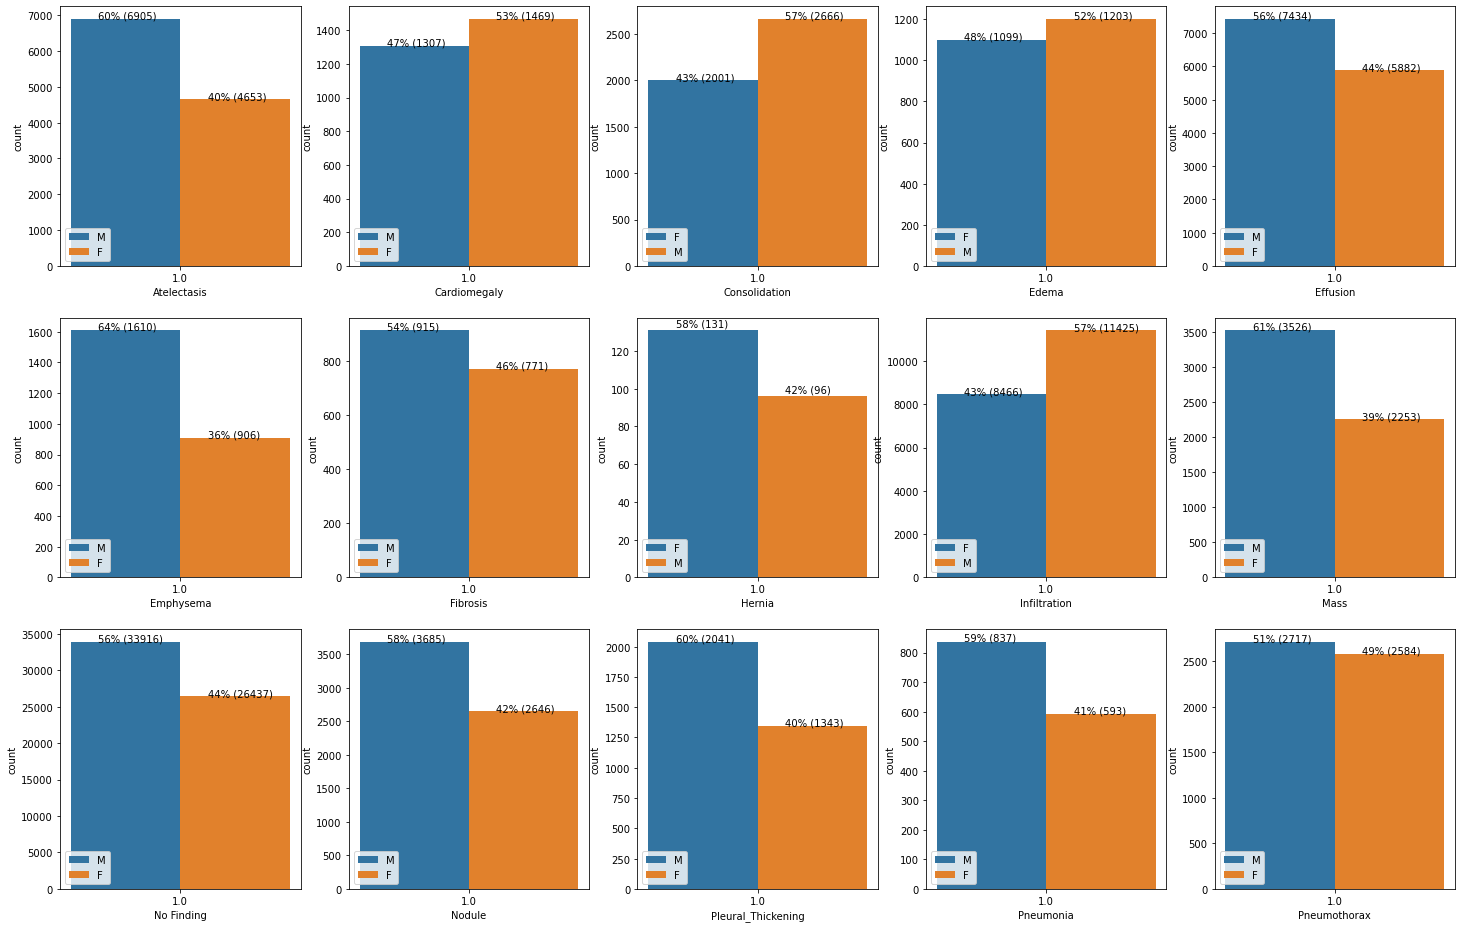

In [20]:
# visualize the distribution of positive cases [1] for each disease grouped by gender
plt.figure(figsize=(25,85))

for i, col in enumerate(all_labels):
    plt.subplot(len(all_labels), 5, i + 1)
    countplot(x=col, hue='Patient Gender', data=all_xray_df[all_xray_df[col]==1])
    plt.legend(loc='lower left')

This dataset shows that 56% of the no-finding cases occur in males while 44% occur in females.
Looking at our target variable (pneumonia), 59% of the positive cases occur in males while 41% in females.

# Relationship between age and disease

In [21]:
# calculate Shapiro Wilk test to test for the normality of the distribution of patient's age grouped by disease
for i in all_labels:
    print('{:14}'.format(i), 'Neg\t', round(shapiro([group["Patient Age"].values for name, group in all_xray_df.groupby(i)][0])[1], 2))
    print('{:14}'.format(i), 'Pos\t', round(shapiro([group["Patient Age"].values for name, group in all_xray_df.groupby(i)][1])[1], 2))    

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Atelectasis    Neg	 0.0
Atelectasis    Pos	 0.0
Cardiomegaly   Neg	 0.0
Cardiomegaly   Pos	 0.0
Consolidation  Neg	 0.0
Consolidation  Pos	 0.0
Edema          Neg	 0.0
Edema          Pos	 0.0
Effusion       Neg	 0.0
Effusion       Pos	 0.0
Emphysema      Neg	 0.0
Emphysema      Pos	 0.0
Fibrosis       Neg	 0.0
Fibrosis       Pos	 0.0
Hernia         Neg	 0.0
Hernia         Pos	 0.0
Infiltration   Neg	 0.0
Infiltration   Pos	 0.0
Mass           Neg	 0.0
Mass           Pos	 0.0
No Finding     Neg	 0.0
No Finding     Pos	 0.0
Nodule         Neg	 0.0
Nodule         Pos	 0.0
Pleural_Thickening Neg	 0.0
Pleural_Thickening Pos	 0.0
Pneumonia      Neg	 0.0
Pneumonia      Pos	 0.0
Pneumothorax   Neg	 0.0
Pneumothorax   Pos	 0.0


Since the p-values for Shapiro-Wilk are <0.05, this means that the distributions are not normally distributed. Hence, I will run the Kruskal-Wallis test to test for any significance in the differences in patient's age between the positive and negative cases of each disease.

In [22]:
for i in all_labels:
    print('{:14}'.format(i), '\t', round(kruskal(*[group["Patient Age"].values for name, group in all_xray_df.groupby(i)])[1], 2))

Atelectasis    	 0.0
Cardiomegaly   	 0.28
Consolidation  	 0.8
Edema          	 0.0
Effusion       	 0.0
Emphysema      	 0.0
Fibrosis       	 0.0
Hernia         	 0.0
Infiltration   	 0.0
Mass           	 0.0
No Finding     	 0.0
Nodule         	 0.0
Pleural_Thickening 	 0.0
Pneumonia      	 0.0
Pneumothorax   	 0.2


The p-values for the Kruskal-Wallis test for Cardiomegaly, Consolidation, and pneumothorax are >0.05, hence we conclude that there is no stataistical significance in the differences in patient's age between the positive and negative cases of these diseases.

For all other diseases (including Pneumonia), the p-values are <0.05, hence we conclude that there is statistical significance in the differences in patient's age between the positive and negative cases of these diseases. We can visualize these by the following boxplots:

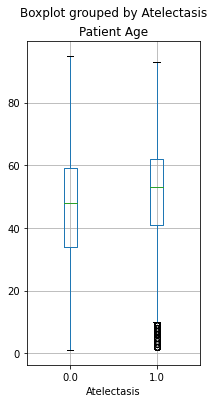

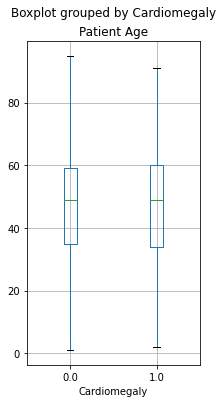

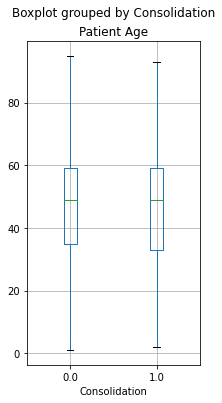

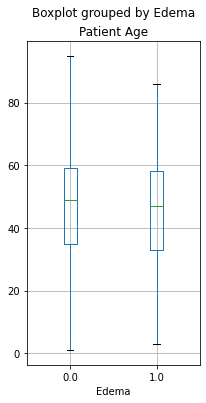

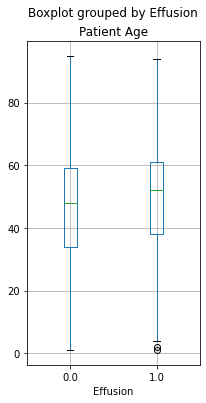

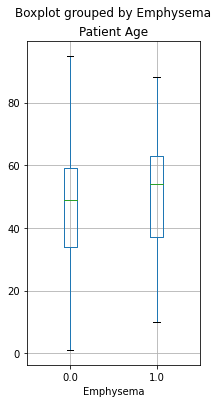

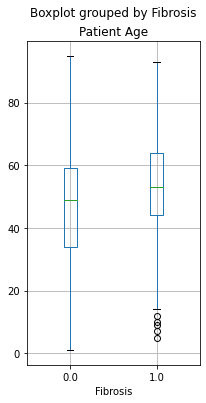

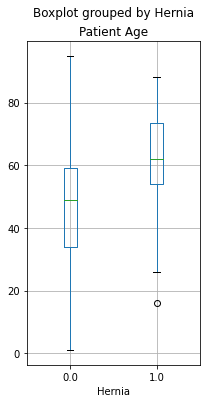

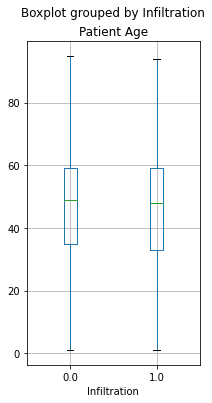

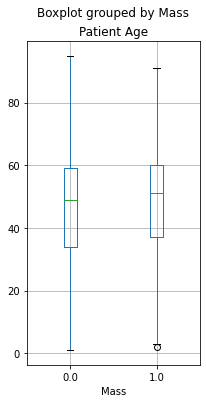

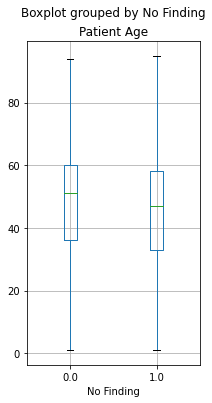

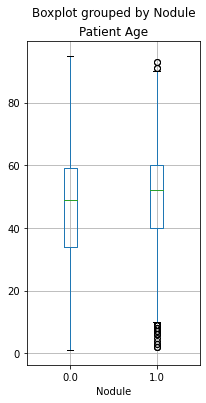

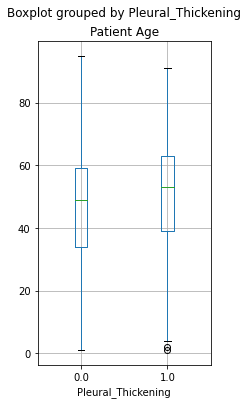

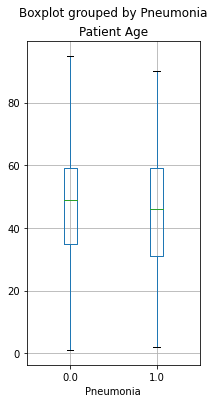

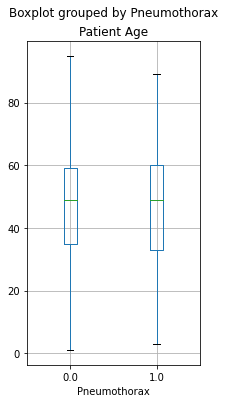

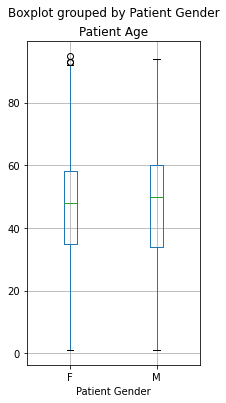

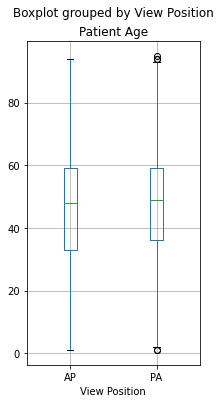

In [23]:
for i in col_cat:
  all_xray_df.boxplot('Patient Age', by = i, figsize=(3,6))

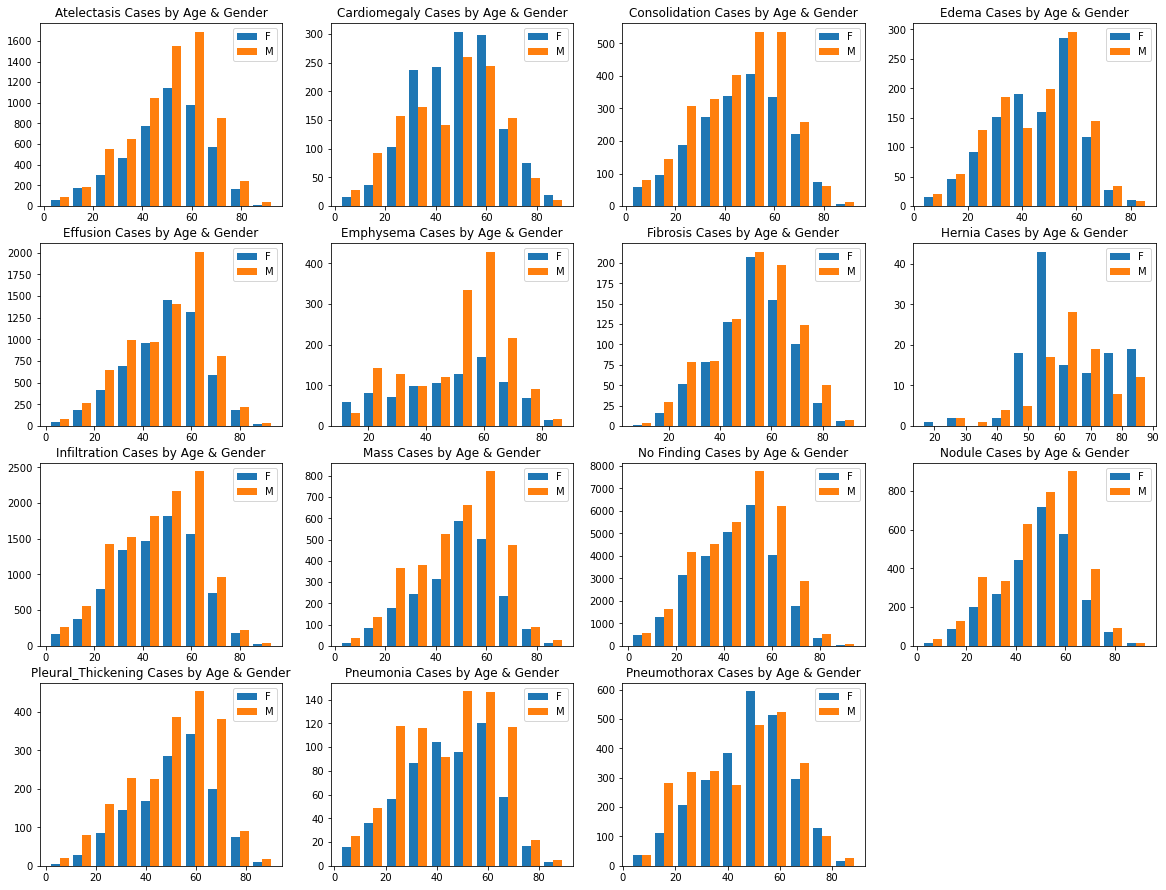

In [24]:
# plot histogram of disease (number of cases) by age (x-axis), grouped by gender
plt.figure(figsize=(20,60))

col_cat2 = col_cat.copy()
col_cat2.remove('Patient Gender')
col_cat2.remove('View Position')

for i, col in enumerate(col_cat2):
  plt.subplot(len(col_cat2), 4, i+1)
  plt.hist([*[group['Patient Age'].values for name, group in all_xray_df[col_cat + ['Patient Age']][all_xray_df[col]==1].groupby('Patient Gender')]], 
           label = [name for name, group in all_xray_df[col_cat + ['Patient Age']][all_xray_df[col]==1].groupby('Patient Gender')])
  plt.title(col+' Cases by Age & Gender')
#   plt.xlabel('Age')
  plt.legend()

Based on the distribution, certain diseases like cardiomegaly affect more females than males, while others like emphysema affect more males than females. In general, the number of cases is highest for those in the middle age.

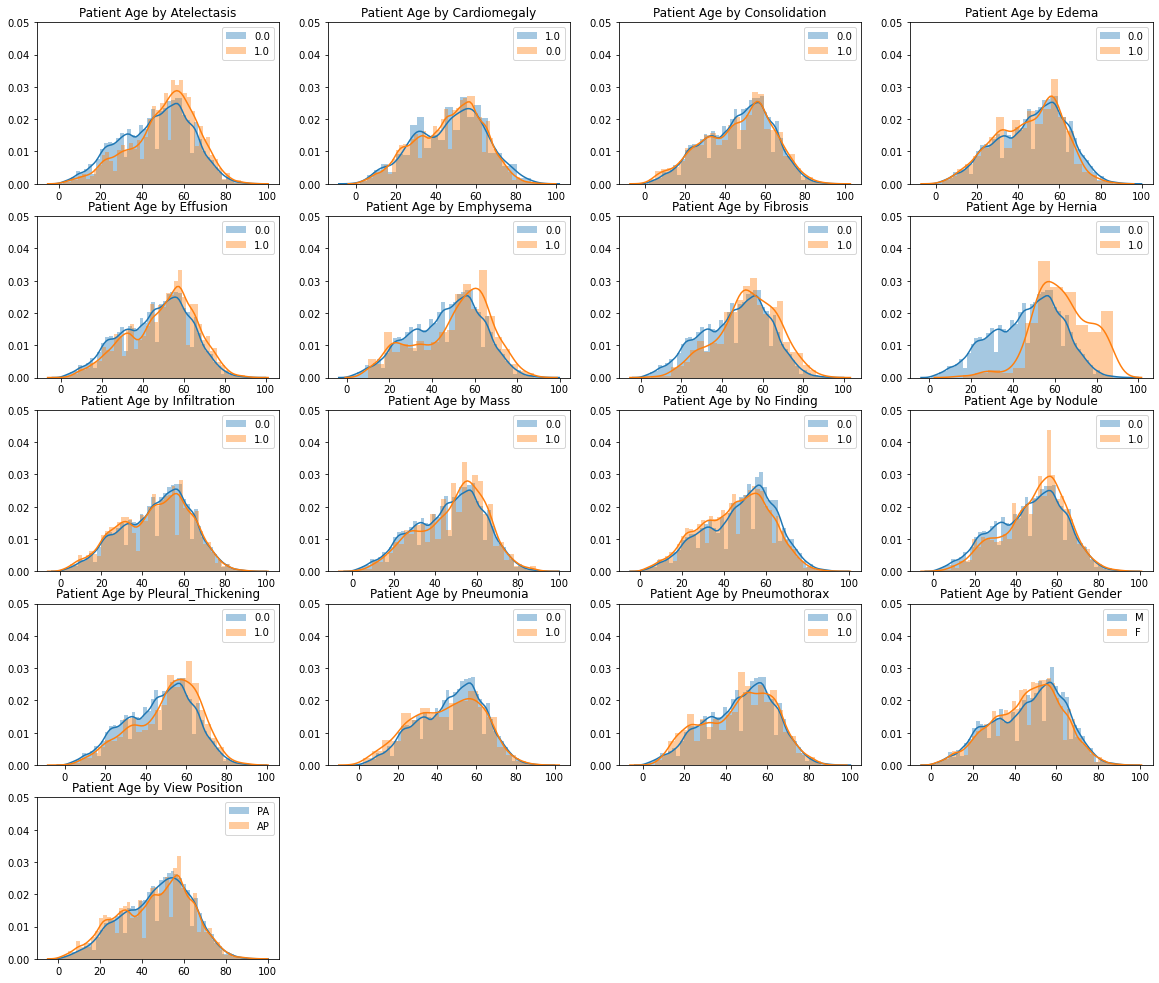

In [25]:
plt.figure(figsize=(20,60))

for i, col in enumerate(col_cat):
  plt.subplot(len(col_cat), 4, i+1)

  for j in all_xray_df[col].unique():
      sns.distplot(all_xray_df['Patient Age'][all_xray_df[col]==j], label = j)

  plt.legend()
  plt.xlabel('')
  plt.ylim(0,0.05)
  plt.title('Patient Age by {}'.format(col))

In general, the distribution of patient age by diseases is similar for those with and without the disease. However, hernia stands out as those with the disease tend to be in their 50's to 80's.

Text(0.5, 1.0, 'Female Patient Age, Pneumonia vs Normal')

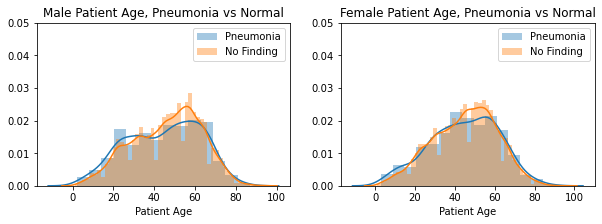

In [26]:
# inspect patient age for pneumonia (target variable) against normal, non-pneumonia cases
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.distplot(all_xray_df.query('Pneumonia == 1 & `Patient Gender` == "M"')['Patient Age'], label='Pneumonia')
sns.distplot(all_xray_df.query('`No Finding` == 1 & `Patient Gender` == "M"')['Patient Age'], label='No Finding')
plt.legend()
# plt.xlabel('')
plt.ylim(0,0.05)
plt.title('Male Patient Age, Pneumonia vs Normal'.format(col))

plt.subplot(1,2,2)
sns.distplot(all_xray_df.query('Pneumonia == 1 & `Patient Gender` == "F"')['Patient Age'], label='Pneumonia')
sns.distplot(all_xray_df.query('`No Finding` == 1 & `Patient Gender` == "F"')['Patient Age'], label='No Finding')
plt.legend()
# plt.xlabel('')
plt.ylim(0,0.05)
plt.title('Female Patient Age, Pneumonia vs Normal'.format(col))

In [27]:
# Number of disease per patient
col_disease = all_labels.copy()
col_disease.remove('No Finding')

disease_per_patient_df = all_xray_df[['Patient ID', 'No Finding'] + col_disease].groupby('Patient ID').max()
disease_per_patient_df['Num_Disease'] = np.sum(disease_per_patient_df, axis=1)
disease_per_patient_df['Num_Disease'] = disease_per_patient_df['Num_Disease'] - disease_per_patient_df['No Finding']

disease_per_patient_df.sort_values(by='Num_Disease', ascending=False)

,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Num_Disease
Patient ID,,,,,,,,,,,,,,,,
16778,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0
12021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0
26451,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0
14022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0
12834,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13137,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pixel-level Assessments
Pixel-level assessments of imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases. The EDA will be performed using sample_df (sample_labels.csv)

In [28]:
## Here I'm going to split up my "Finding Labels" column so that I have one column per disease in my dataframe,
# with a binary flag (0 for Yes; 1 for No). This makes EDA a lot easier! 

all_labels_sample = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels_sample = [x for x in all_labels_sample if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels_sample), all_labels_sample))

for i in all_labels_sample:
    if len(i) > 1: # leave out empty labels
        sample_df[i] = sample_df['Finding Labels'].map(lambda x: 1.0 if i in x else 0)
        
col_disease_sample = all_labels_sample.copy()
col_disease_sample.remove('No Finding')

disease_per_patient_sample_df = sample_df[['Patient ID', 'Image Index', 'No Finding'] + col_disease_sample].groupby('Patient ID').max()
disease_per_patient_sample_df['Num_Disease'] = np.sum(disease_per_patient_sample_df, axis=1)
disease_per_patient_sample_df['Num_Disease'] = disease_per_patient_sample_df['Num_Disease'] - disease_per_patient_sample_df['No Finding']

disease_per_patient_sample_df[disease_per_patient_sample_df['Pneumonia']==1]

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Num_Disease
Patient ID,,,,,,,,,,,,,,,,,
1373,00001373_052.png,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
1529,00001529_004.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
1993,00001993_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0
3789,00003789_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0
4074,00004074_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0
4075,00004075_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
5681,00005681_032.png,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
6843,00006843_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
7007,00007007_016.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


## Pneumonia

Pneumonia


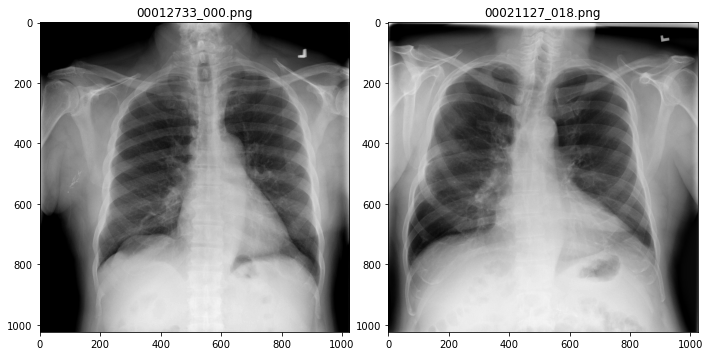

In [29]:
# For Pneumonia case
# plot sample image
print('Pneumonia')

image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
plt.figure(figsize=(10,10))

image_sample = disease_per_patient_sample_df.query('`Pneumonia` == 1 & Num_Disease == 1')['Image Index'][3:5]
columns = 2

for i, image_name in enumerate(image_sample):
    plt.subplot(2/columns + 1, columns, i + 1)
    
    image = plt.imread(image_paths[image_name])
    plt.tight_layout()
    plt.imshow(image, cmap = "gray")
    plt.title(image_name)

00012733_000.png
Pneumonia case mean intensity: 0.44965848
Pneumonia case  std intensity: 0.26966643
00021127_018.png
Pneumonia case mean intensity: 0.52192706
Pneumonia case  std intensity: 0.25434375


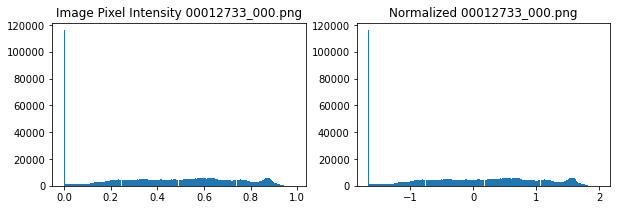

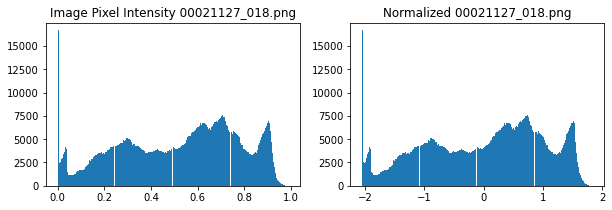

In [30]:
for i, image_name in enumerate(image_sample):   
    sample_image = plt.imread(image_paths[image_name])

    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(sample_image.ravel(), bins = 256)
    
    plt.title('Image Pixel Intensity {}'.format(image_name))

    # Pixel average
    mean_intensity = np.mean(sample_image)
    std_intensity = np.std(sample_image)

    print(image_name)
    print("Pneumonia case mean intensity:", mean_intensity)
    print("Pneumonia case  std intensity:",std_intensity)

    new_img = sample_image.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    plt.subplot(1,2,2)
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Normalized {}'.format(image_name))

All pneumonia cases mean intensity: 0.48836583
All pneumonia cases  std intensity: 0.16683678


Text(0.5, 1.0, 'Normalized')

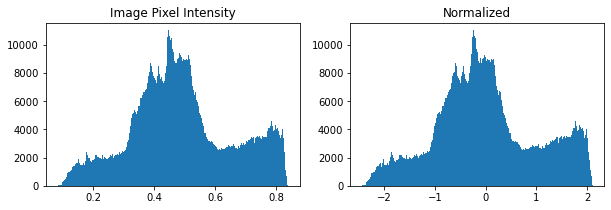

In [31]:
# sum all x-ray pixels of all pneumonia cases & calculate the average 
image_sample = disease_per_patient_sample_df.query('`Pneumonia` == 1')['Image Index']#.to_list()

image_pxl_sum = []
for i, image_name in enumerate(image_sample):    
    image = plt.imread(image_paths[image_name])
    if image.shape == (1024,1024):
        image_pxl_sum.append(image)

image_pxl_sum = np.sum(image_pxl_sum, axis=0)/len(image_pxl_sum)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(image_pxl_sum.ravel(), bins = 256)

plt.title('Image Pixel Intensity')#.format(image_name))

# Pixel average
mean_intensity = np.mean(image_pxl_sum)
std_intensity = np.std(image_pxl_sum)

print("All pneumonia cases mean intensity:", mean_intensity)
print("All pneumonia cases  std intensity:",std_intensity)

new_img = image_pxl_sum.copy()
new_img = (new_img - mean_intensity)/std_intensity

plt.subplot(1,2,2)
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')# {}'.format(image_name))

In [32]:
# find the mode of the samples
mode(image_pxl_sum.ravel())[0][0]

0.5019608

In [33]:
# normalized mode
mode(new_img.ravel()[new_img.ravel()>0])[0][0]

0.08148674

Single-disease pneumonia cases mean intensity: 0.4677552
Single-disease pneumonia cases  std intensity: 0.20763205


Text(0.5, 1.0, 'Normalized')

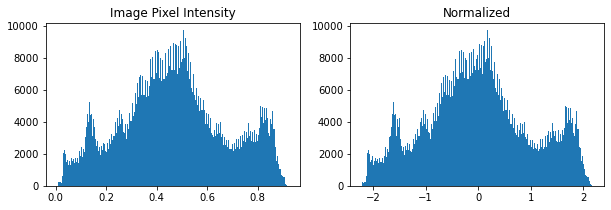

In [34]:
# sum all x-ray pixels of single-disease pneumonia cases & calculate the average 
image_sample = disease_per_patient_sample_df.query('`Pneumonia` == 1 & Num_Disease == 1')['Image Index']

image_pxl_sum = []
for i, image_name in enumerate(image_sample):    
    image = plt.imread(image_paths[image_name])
    image_pxl_sum.append(image)

image_pxl_sum = np.sum(image_pxl_sum, axis=0)/len(image_pxl_sum)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(image_pxl_sum.ravel(), bins = 256)

plt.title('Image Pixel Intensity')#.format(image_name))

# Pixel average
mean_intensity = np.mean(image_pxl_sum)
std_intensity = np.std(image_pxl_sum)

print("Single-disease pneumonia cases mean intensity:", mean_intensity)
print("Single-disease pneumonia cases  std intensity:",std_intensity)

new_img = image_pxl_sum.copy()
new_img = (new_img - mean_intensity)/std_intensity

plt.subplot(1,2,2)
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')# {}'.format(image_name))

In [35]:
# find the mode of the samples
mode(image_pxl_sum.ravel())[0][0]

0.50392157

In [36]:
# normalized mode
mode(new_img.ravel()[new_img.ravel()>0])[0][0]

0.1741849

## Non-pneumonia (No Finding)

In [ ]:
# For non-pneumonia case
# plot sample image
print('Non-Pneumonia')

image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
plt.figure(figsize=(10,10))

image_sample = disease_per_patient_sample_df.query('Pneumonia != 1')['Image Index'][1:3]
columns = 2

for i, image_name in enumerate(image_sample):
    plt.subplot(2/columns + 1, columns, i + 1)
    
    image = plt.imread(image_paths[image_name])
    plt.tight_layout()
    plt.imshow(image, cmap = "gray")
    plt.title(image_name)

00000017_001.png
Non-pneumonia case mean intensity: 0.61305344
Non-pneumonia case  std intensity: 0.21937871
00000030_001.png
Non-pneumonia case mean intensity: 0.48619363
Non-pneumonia case  std intensity: 0.25896254


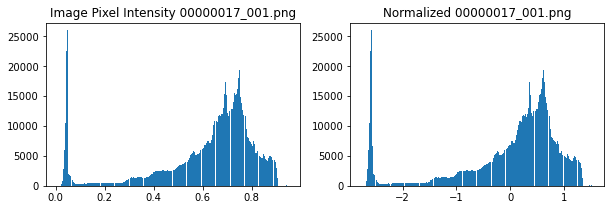

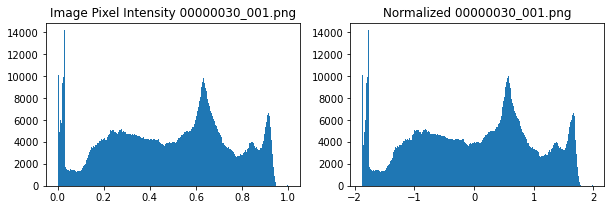

In [50]:
for i, image_name in enumerate(image_sample):   
    sample_image = plt.imread(image_paths[image_name])

    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(sample_image.ravel(), bins = 256)
    
    plt.title('Image Pixel Intensity {}'.format(image_name))

    # Pixel average
    mean_intensity = np.mean(sample_image)
    std_intensity = np.std(sample_image)

    print(image_name)
    print("Non-pneumonia case mean intensity:", mean_intensity)
    print("Non-pneumonia case  std intensity:",std_intensity)

    new_img = sample_image.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    plt.subplot(1,2,2)
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Normalized {}'.format(image_name))

In [52]:
# to do: try to rerun using Udacity's GPU
# sum all x-ray pixels of all pneumonia cases & calculate the average 
image_sample = disease_per_patient_sample_df.query('`Pneumonia` != 1')['Image Index']

image_pxl_sum = []
for i, image_name in enumerate(image_sample):    
    image = plt.imread(image_paths[image_name])
    if image.shape == (1024,1024):
        image_pxl_sum.append(image)

image_pxl_sum = np.sum(image_pxl_sum, axis=0)/len(image_pxl_sum)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(image_pxl_sum.ravel(), bins = 256)

plt.title('Image Pixel Intensity')

# Pixel average
mean_intensity = np.mean(image_pxl_sum)
std_intensity = np.std(image_pxl_sum)

print("All non-pneumonia cases mean intensity:", mean_intensity)
print("All non-pneumonia cases  std intensity:",std_intensity)

new_img = image_pxl_sum.copy()
new_img = (new_img - mean_intensity)/std_intensity

plt.subplot(1,2,2)
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')

MemoryError: Unable to allocate 16.2 GiB for an array with shape (4151, 1024, 1024) and data type float32

In [ ]:
mode(image_pxl_sum.ravel()[image_pxl_sum.ravel()>0])[0][0]

In [ ]:
mode(new_img.ravel()[new_img.ravel()>0])[0][0]

# Conclusion (to do)

In this dataset, 'No Finding' is the most common occurrence (~54%). In terms of diseases, 'Infiltration' occurs most frequently, followed by 'Effusion' and 'Atelectasis'.

For our target variable Pneumonia, the most common comorbidities are Infiltration and Edema, followed by Atelectasis. Below are some statistics for pneumonia compared to non-pneumonia:

Pneumonia
- male
- female
- age

Non-pneumonia (but includes other diseases)


No finding (no disease)

